In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df1 = pd.read_csv('data_orders.csv')
df1.head()

order_datetime  origin_longitude  origin_latitude  m_order_eta  \
0       18:08:07         -0.978916        51.456173         60.0   
1       20:57:32         -0.950385        51.456843          NaN   
2       12:07:50         -0.969520        51.455544        477.0   
3       13:50:20         -1.054671        51.460544        658.0   
4       21:24:45         -0.967605        51.458236          NaN   

        order_gk  order_status_key  is_driver_assigned_key  \
0  3000583041974                 4                       1   
1  3000583116437                 4                       0   
2  3000582891479                 4                       1   
3  3000582941169                 4                       1   
4  3000583140877                 9                       0   

   cancellations_time_in_seconds  
0                          198.0  
1                          128.0  
2                           46.0  
3                           62.0  
4                            NaN

In [9]:
df2 = pd.read_csv('data_offers.csv')
df2.head()

order_gk      offer_id
0  3000579625629  300050936206
1  3000627306450  300052064651
2  3000632920686  300052408812
3  3000632771725  300052393030
4  3000583467642  300051001196

In [10]:
df = pd.merge(df1, df2, on='order_gk')

# Display the merged dataset
df.head()

order_datetime  origin_longitude  origin_latitude  m_order_eta  \
0       18:08:07         -0.978916        51.456173         60.0   
1       20:57:32         -0.950385        51.456843          NaN   
2       20:57:32         -0.950385        51.456843          NaN   
3       20:57:32         -0.950385        51.456843          NaN   
4       12:07:50         -0.969520        51.455544        477.0   

        order_gk  order_status_key  is_driver_assigned_key  \
0  3000583041974                 4                       1   
1  3000583116437                 4                       0   
2  3000583116437                 4                       0   
3  3000583116437                 4                       0   
4  3000582891479                 4                       1   

   cancellations_time_in_seconds      offer_id  
0                          198.0  300050983403  
1                          128.0  300050986179  
2                          128.0  300050986174  
3                          128.0  300050986180  
4                           46.0  300050976275

In [11]:
df.isna().sum()

order_datetime                       0
origin_longitude                     0
origin_latitude                      0
m_order_eta                      22904
order_gk                             0
order_status_key                     0
is_driver_assigned_key               0
cancellations_time_in_seconds     9473
offer_id                             0
dtype: int64

In [14]:
# Task 1: Distribution of orders according to reasons for failure
df['failure_reason'] = 'Success'  # Initialize with Success
df.loc[df['order_status_key'] == 4, 'failure_reason'] = 'Cancelled by Client'
df.loc[df['order_status_key'] == 9, 'failure_reason'] = 'Cancelled by System'

failure_reason_counts = df['failure_reason'].value_counts()

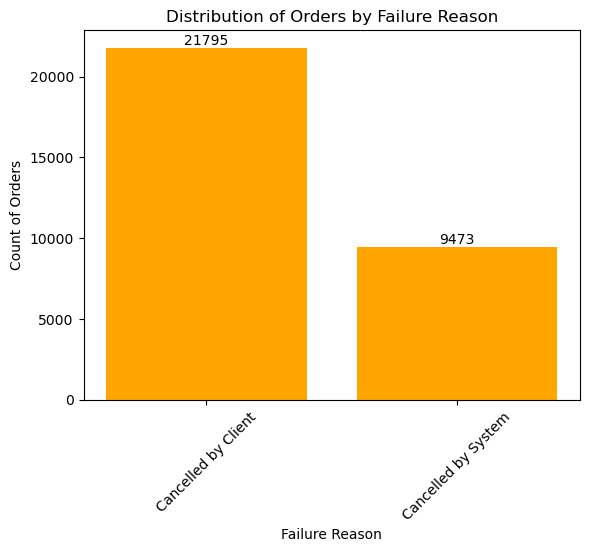

In [15]:
plt.bar(failure_reason_counts.index, failure_reason_counts.values, color='orange')  # Changed color to orange
plt.xlabel('Failure Reason')
plt.ylabel('Count of Orders')
plt.title('Distribution of Orders by Failure Reason')
plt.xticks(rotation=45)

# Add labels to the bars
for i, count in enumerate(failure_reason_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [16]:
highest_category = failure_reason_counts.idxmax()
highest_count = failure_reason_counts.max()

print("Category with the highest number of orders:", highest_category)
print("Count of orders in the highest category:", highest_count)

Category with the highest number of orders: Cancelled by Client
Count of orders in the highest category: 21795


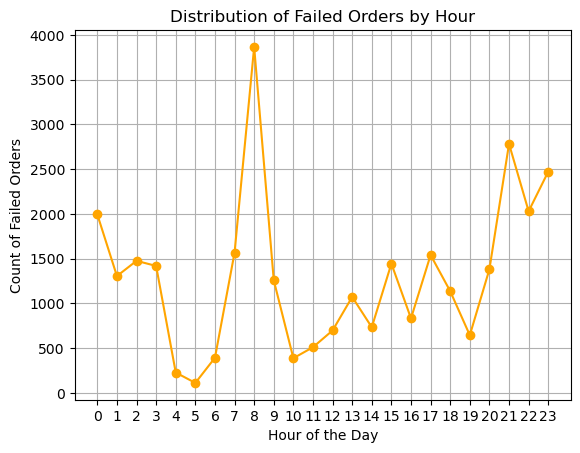

In [18]:
# Task 2: Distribution of failed orders by hours
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df['order_hour'] = df['order_datetime'].dt.hour

failed_orders = df[df['failure_reason'] != 'Success']
failed_orders_by_hour = failed_orders['order_hour'].value_counts().sort_index()

plt.plot(failed_orders_by_hour.index, failed_orders_by_hour.values, marker='o', color='orange')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Failed Orders')
plt.title('Distribution of Failed Orders by Hour')
plt.xticks(range(24))
plt.grid(True)
plt.show()

In [20]:
print("Hour(s) with the most failed orders:", failed_orders_by_hour.idxmax())
print("Exact count of failed orders during the most failed hour(s):", failed_orders_by_hour.max())

Hour(s) with the most failed orders: 8
Exact count of failed orders during the most failed hour(s): 3865


In [28]:
# Task 3: Average time to cancellation with and without a driver, by the hour

# Filter out successful orders (i.e., not cancelled)
df_cancelled = df[df['failure_reason'] != 'Success']

# Calculate quartiles for cancellation time
Q1 = df_cancelled['cancellations_time_in_seconds'].quantile(0.25)
Q3 = df_cancelled['cancellations_time_in_seconds'].quantile(0.75)

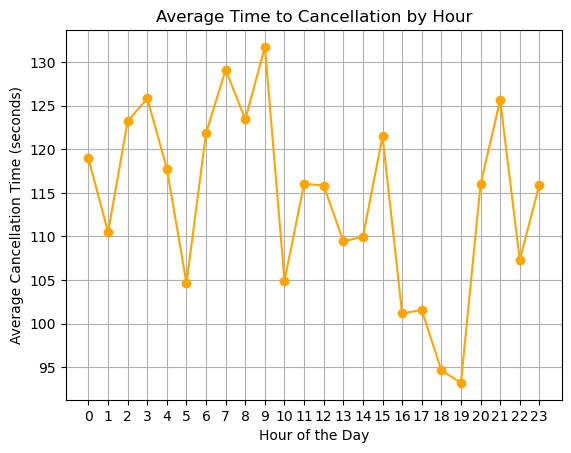

In [31]:
# Calculate interquartile range (IQR)
IQR = Q3 - Q1

# Filter out outliers using IQR method
df_cancelled = df_cancelled[
    (df_cancelled['cancellations_time_in_seconds'] >= Q1 - 1.5 * IQR) &
    (df_cancelled['cancellations_time_in_seconds'] <= Q3 + 1.5 * IQR)
]

# Group by hour and calculate average cancellation time
avg_cancellation_time = df_cancelled.groupby('order_hour')['cancellations_time_in_seconds'].mean()

# Plot the average time to cancellation by hour
plt.plot(avg_cancellation_time.index, avg_cancellation_time.values, marker='o', color='orange')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Cancellation Time (seconds)')
plt.title('Average Time to Cancellation by Hour')
plt.xticks(range(24))
plt.grid(True)
plt.show()

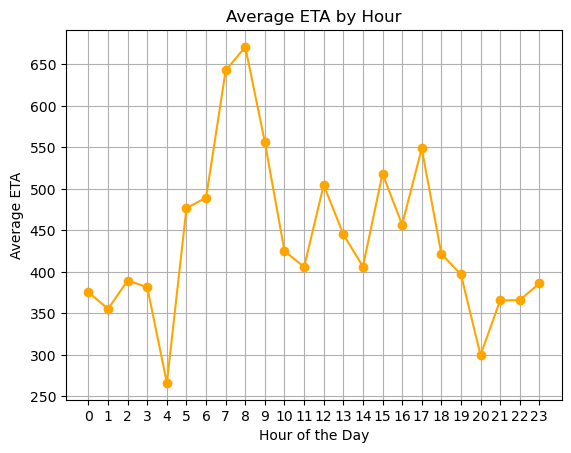

In [32]:
# Task 4: Distribution of average ETA by hours
avg_eta_by_hour = df.groupby('order_hour')['m_order_eta'].mean()

plt.plot(avg_eta_by_hour.index, avg_eta_by_hour.values, marker='o', color='orange')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA')
plt.title('Average ETA by Hour')
plt.xticks(range(24))
plt.grid(True)
plt.show()

In [35]:
import folium
import h3

# Load the original dataset containing order locations
data_orders = pd.read_csv("data_orders.csv")  # Adjust the filename as necessary

# Calculate H3 hexagons for each order location with resolution 8
data_orders['h3_hex'] = data_orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

# Define a function to determine failure reason
def determine_failure(row):
    if row['order_status_key'] in [4, 9]:
        return 'Failure'
    else:
        return 'Success'

# Apply the function to create a failure_reason column
data_orders['failure_reason'] = data_orders.apply(determine_failure, axis=1)

# Aggregate the orders within each hexagon, counting the number of failed orders
hex_counts = data_orders.groupby('h3_hex')['failure_reason'].apply(lambda x: (x == 'Failure').sum()).reset_index(name='fail_count')

# Sort the hexagons by fail count in descending order
hex_counts = hex_counts.sort_values(by='fail_count', ascending=False)

# Calculate the cumulative sum of orders
hex_counts['cumulative_sum'] = hex_counts['fail_count'].cumsum()

# Determine the hexagons containing 80% of all orders
threshold = hex_counts['fail_count'].sum() * 0.8
selected_hexes = hex_counts[hex_counts['cumulative_sum'] <= threshold]

# Visualize the selected hexagons on a map, coloring them by the number of failed orders
m = folium.Map(location=[data_orders['origin_latitude'].mean(), data_orders['origin_longitude'].mean()], zoom_start=10)

for index, row in selected_hexes.iterrows():
    h3_boundary = h3.h3_to_geo_boundary(row['h3_hex'])
    folium.Polygon(locations=h3_boundary, fill_color='red', fill_opacity=0.6, color='black', weight=1).add_to(m)

m.save('selected_hexagons_map.html')